<a href="https://colab.research.google.com/github/msrepo/ml-mscise-2023/blob/master/deep_learning/examples/cnn_cifar_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original notebook: Probabilistic Machine Learning, Kevin Murphy

[Original Github repo
](https://github.com/probml)

### CNN for image classification using Pytorch

In this section, we follow Chap 8 of Deep Learning with Pytorch book, and illustrate how to fit a CNN to two-class version of CIFAR.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from functools import partial
import os
import collections
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

## Get data
The images are mean centered. The mean/std of RGB channels are precomputed.

In [3]:


class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

from torchvision import datasets, transforms

data_path = "data"
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]
    ),
)

cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]
    ),
)
     


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Basics of Convolution

Lets apply a set of convolution kernels to a grayscale image

In [4]:
label_map = {0:0, 2:1}
class_names = ['plane', 'bird']
nclasses = 2
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]


In [5]:
img, label = cifar2[0]
img_t = img.unsqueeze(0)
print(img_t.shape)

nfeatures = 16
kernel_size = 3
conv = nn.Conv2d(3, nfeatures, kernel_size= kernel_size)
output = conv(img_t)
print(output.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 16, 30, 30])


Now we add paddig to ensure output size in same as input

In [6]:
nfeatures = 16
kernel_size = 3
pad = kernel_size // 2
conv = nn.Conv2d(3, nfeatures, kernel_size=kernel_size, padding=pad)

output = conv(img_t)
print(output.shape)

torch.Size([1, 16, 32, 32])


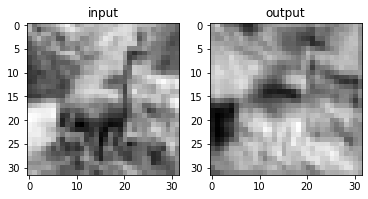

In [7]:
def show_results(img_batch, output_batch, index=0, channel=0):
  ax1 = plt.subplot(1,2,1)
  img = img_batch[index]
  plt.imshow(img.mean(0), cmap='gray')
  plt.title('input')
  plt.subplot(1,2,2)
  plt.title('output')
  out = output_batch[index, channel]
  plt.imshow(out.detach(), cmap='gray')
  plt.show()

show_results(img_t, output)

currently the filter parameters are random

In [8]:
print(conv)
print(conv.weight.shape)
print(conv.bias.shape)
print(conv.weight[0,...])

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([16, 3, 3, 3])
torch.Size([16])
tensor([[[-0.1357, -0.0052, -0.1750],
         [-0.0502, -0.1305, -0.0960],
         [ 0.1217,  0.0568, -0.0085]],

        [[-0.0694,  0.0495,  0.0499],
         [ 0.1763,  0.0076,  0.0211],
         [-0.0838,  0.1587, -0.1709]],

        [[ 0.0200,  0.0612,  0.0432],
         [-0.1737, -0.1608, -0.0927],
         [ 0.0316, -0.1292, -0.1491]]], grad_fn=<SelectBackward0>)


Lets make the first filter just be an averaging operation

tensor([[[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]],

        [[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]],

        [[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]]], grad_fn=<SelectBackward0>)


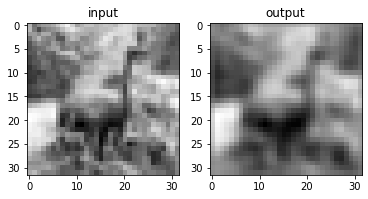

In [9]:
with torch.no_grad():
  conv.bias.zero_()

with torch.no_grad():
  conv.weight.fill_(1.0 / 9.0)
print(conv.weight[0,...])

output = conv(img_t)
show_results(img_t, output)

Lets make the first filter be a vertical edge detector.

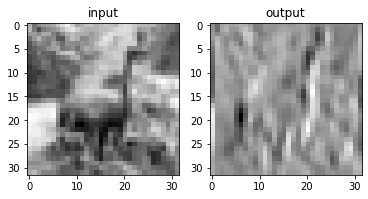

In [10]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
  conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0]])
  conv.bias.zero_()

output = conv(img_t)
show_results(img_t, output)

## Maxpooling

We can reduce the ize of the internal feature maps using maxpooling

torch.Size([1, 3, 16, 16])


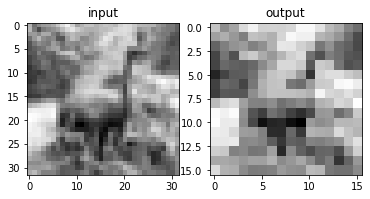

In [11]:
pool = nn.MaxPool2d(2)
output = pool(img_t)
print(output.shape)

show_results(img_t, output)

## Making our first CNN

In [12]:
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, nclasses, img, nchans1=16, nhidden=32):
    super().__init__()
    nchannels, nrows, ncols = img.shape
    self.nchans1 = nchans1
    self.nchans2 = nchans1 // 2
    self.nhidden = nhidden
    self.nclasses = nclasses
    self.conv1 = nn.Conv2d(nchannels, self.nchans1, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(nchans1, self.nchans2, kernel_size=3, padding=1)

    self.nflat = nrows // 4 * ncols // 4
    self.fc1 = nn.Linear(self.nchans2 * self.nflat, self.nhidden)
    self.fc2 = nn.Linear(self.nhidden, self.nclasses)

  def forward(self,x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
    out = out.view(-1, self.nchans2 * self.nflat)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

In [13]:
set_seed(1)
img_batch = img_t.to(device=device)
model = Net(nclasses, img_batch[0]).to(device=device)
out_batch = model(img_batch)
print(out_batch.shape)
print(out_batch)

torch.Size([1, 2])
tensor([[-0.2489,  0.2137]], grad_fn=<AddmmBackward0>)


Training Loop

In [14]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, l2_regularizer=0, print_every=5):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)

      l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
      loss = loss + l2_regularizer * l2_norm

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()

    if epoch == 1 or epoch % print_every == 0:
      print(f'{datetime.datetime.now()} Epoch {epoch}, Training loss {loss_train / len(train_loader)}')

In [15]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net(nclasses, img_batch[0]).to(device=device)
optimizer = optim.SGD(model.parameters(), lr= 1e-2)
loss_fn  = nn.CrossEntropyLoss()

training_loop (
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2022-12-14 13:36:07.014195 Epoch 1, Training loss 0.5650579876201168
2022-12-14 13:36:25.632451 Epoch 5, Training loss 0.4238025394214946
2022-12-14 13:36:49.956949 Epoch 10, Training loss 0.3414505463876542
2022-12-14 13:37:13.687462 Epoch 15, Training loss 0.31660129936637393
2022-12-14 13:37:36.935452 Epoch 20, Training loss 0.3013431436506806
2022-12-14 13:38:01.050653 Epoch 25, Training loss 0.2852057010694674
2022-12-14 13:38:24.925493 Epoch 30, Training loss 0.2694763391260888
2022-12-14 13:38:48.473121 Epoch 35, Training loss 0.25984605790892984
2022-12-14 13:39:11.748746 Epoch 40, Training loss 0.24815881375674229
2022-12-14 13:39:35.342485 Epoch 45, Training loss 0.2372640558773545
2022-12-14 13:39:58.252834 Epoch 50, Training loss 0.2263645263993816


## Validation accuracy

In [16]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def accuracy(model, loader):
  correct = 0
  total = 0
  with torch.no_grad():
    for imgs, labels in loader:
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, dim=1)
      total += labels.shape[0] # batch size
      correct += int((predicted == labels).sum())
  accuracy = correct / total
  return accuracy

In [17]:
train_acc = accuracy(model, train_loader)
val_acc = accuracy(model, val_loader)
print([train_acc, val_acc])

[0.9086, 0.8825]
